<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 1 | Setup and Analysis</p>

# <b></span><span style='color:#87CEEB'> Importing Necessary Libraries</span></b>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# <b></span><span style='color:#87CEEB'> Load dataware house</span></b>

In [35]:
df_flights = pd.read_csv('viagens/flights_ratings_modelos.csv')

In [36]:
colunas_dataset = ["FL_DATE", "AIRLINE_CODE", "FL_NUMBER","ORIGIN","DEST","DEP_TIME","CRS_DEP_TIME","CRS_ARR_TIME",
                   "ARR_TIME","CANCELLED","DIVERTED","DISTANCE","DELAY_DUE_CARRIER","DELAY_DUE_WEATHER","DELAY_DUE_NAS",
                   "DELAY_DUE_SECURITY","DELAY_DUE_LATE_AIRCRAFT", "Rating", "Modelo Avião"]

In [37]:
df_flights = df_flights[colunas_dataset]

# <b></span><span style='color:#87CEEB'> Initial Data Analysis</span></b>

In [38]:
df_flights.head(10)

,FL_DATE,AIRLINE_CODE,FL_NUMBER,ORIGIN,DEST,DEP_TIME,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,CANCELLED,DIVERTED,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,Rating,Modelo Avião
0,2019-01-09,UA,1562,FLL,EWR,1151.0,1155,1501,1447.0,0.0,0.0,1065.0,NaN,NaN,NaN,NaN,NaN,3.3,Boeing 737-200
1,2022-11-19,DL,1149,MSP,SEA,2114.0,2120,2315,2310.0,0.0,0.0,1399.0,NaN,NaN,NaN,NaN,NaN,1.4,Airbus A340-600
2,2022-07-22,UA,459,DEN,MSP,1000.0,954,1252,1252.0,0.0,0.0,680.0,NaN,NaN,NaN,NaN,NaN,1.2,Boeing 787
3,2023-03-06,DL,2295,MSP,SFO,1608.0,1609,1829,1853.0,0.0,0.0,1589.0,0.0,0.0,24.0,0.0,0.0,3.7,Airbus A330-200
4,2020-02-23,NK,407,MCO,DFW,1838.0,1840,2041,2040.0,0.0,0.0,985.0,NaN,NaN,NaN,NaN,NaN,2.5,Airbus A330-900neo
5,2019-07-31,WN,665,DAL,OKC,1237.0,1010,1110,1331.0,0.0,0.0,181.0,141.0,0.0,0.0,0.0,0.0,5.8,Boeing 767-300
6,2023-06-11,AA,2134,DCA,BOS,1001.0,1010,1159,1130.0,0.0,0.0,399.0,NaN,NaN,NaN,NaN,NaN,1.1,Airbus A310
7,2019-07-08,YX,4464,HSV,DCA,1637.0,1643,1945,2008.0,0.0,0.0,613.0,0.0,0.0,23.0,0.0,0.0,2.6,Boeing 767-300
8,2023-02-12,NK,590,IAH,LAX,527.0,530,717,706.0,0.0,0.0,1379.0,NaN,NaN,NaN,NaN,NaN,3.2,Boeing 767-200
9,2020-08-22,AS,223,SEA,FAI,2116.0,2125,2355,2356.0,0.0,0.0,1533.0,NaN,NaN,NaN,NaN,NaN,3.1,Boeing 787-10


In [39]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 19 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE_CODE             object 
 2   FL_NUMBER                int64  
 3   ORIGIN                   object 
 4   DEST                     object 
 5   DEP_TIME                 float64
 6   CRS_DEP_TIME             int64  
 7   CRS_ARR_TIME             int64  
 8   ARR_TIME                 float64
 9   CANCELLED                float64
 10  DIVERTED                 float64
 11  DISTANCE                 float64
 12  DELAY_DUE_CARRIER        float64
 13  DELAY_DUE_WEATHER        float64
 14  DELAY_DUE_NAS            float64
 15  DELAY_DUE_SECURITY       float64
 16  DELAY_DUE_LATE_AIRCRAFT  float64
 17  Rating                   float64
 18  Modelo Avião             object 
dtypes: float64(11), int64(3), object(5)
memory usage: 434.9+ MB


In [40]:
# Summary statistics for numerical variables
df_flights.describe().T

,count,mean,std,min,25%,50%,75%,max
FL_NUMBER,3000000.0,2511.535519,1747.258040,1.0,1051.0,2152.0,3797.0,9562.0
DEP_TIME,2922385.0,1329.775913,499.310052,1.0,916.0,1323.0,1739.0,2400.0
CRS_DEP_TIME,3000000.0,1327.061984,485.878854,1.0,915.0,1320.0,1730.0,2359.0
CRS_ARR_TIME,3000000.0,1490.560665,511.547566,1.0,1107.0,1516.0,1919.0,2400.0
ARR_TIME,2920058.0,1466.511162,531.838349,1.0,1053.0,1505.0,1913.0,2400.0
CANCELLED,3000000.0,0.026380,0.160263,0.0,0.0,0.0,0.0,1.0
DIVERTED,3000000.0,0.002352,0.048440,0.0,0.0,0.0,0.0,1.0
DISTANCE,3000000.0,809.361552,587.893938,29.0,377.0,651.0,1046.0,5812.0
DELAY_DUE_CARRIER,533863.0,24.759086,71.771845,0.0,0.0,4.0,23.0,2934.0
DELAY_DUE_WEATHER,533863.0,3.985260,32.410796,0.0,0.0,0.0,0.0,1653.0


In [41]:
# Summary statistics for categorical variables
df_flights.describe(include='object').T

,count,unique,top,freq
FL_DATE,3000000,1704,2019-07-25,2379
AIRLINE_CODE,3000000,18,WN,576470
ORIGIN,3000000,380,ATL,153556
DEST,3000000,380,ATL,153569
Modelo Avião,3000000,105,Boeing 747,39647


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Data Cleaning</p>

# <b></span><span style='color:#87CEEB'> Treating Cancelled and Diverted Flights</span></b>

In [42]:
df_cancelados = df_flights[df_flights["CANCELLED"] == 1.0].copy()
df_desviados = df_flights[df_flights["DIVERTED"] == 1.0].copy()

In [43]:
diverted_percentage = (df_desviados.shape[0] / df_flights.shape[0]) * 100
cancelled_percentage = (df_cancelados.shape[0] / df_flights.shape[0]) * 100

In [44]:
print(f"Cancelled flights%: {cancelled_percentage:.2f}\n Diverted flights%: {diverted_percentage:.2f}")

Cancelled flights%: 2.64
 Diverted flights%: 0.24


# <b></span><span style='color:#87CEEB'> Handling Nulls</span></b>

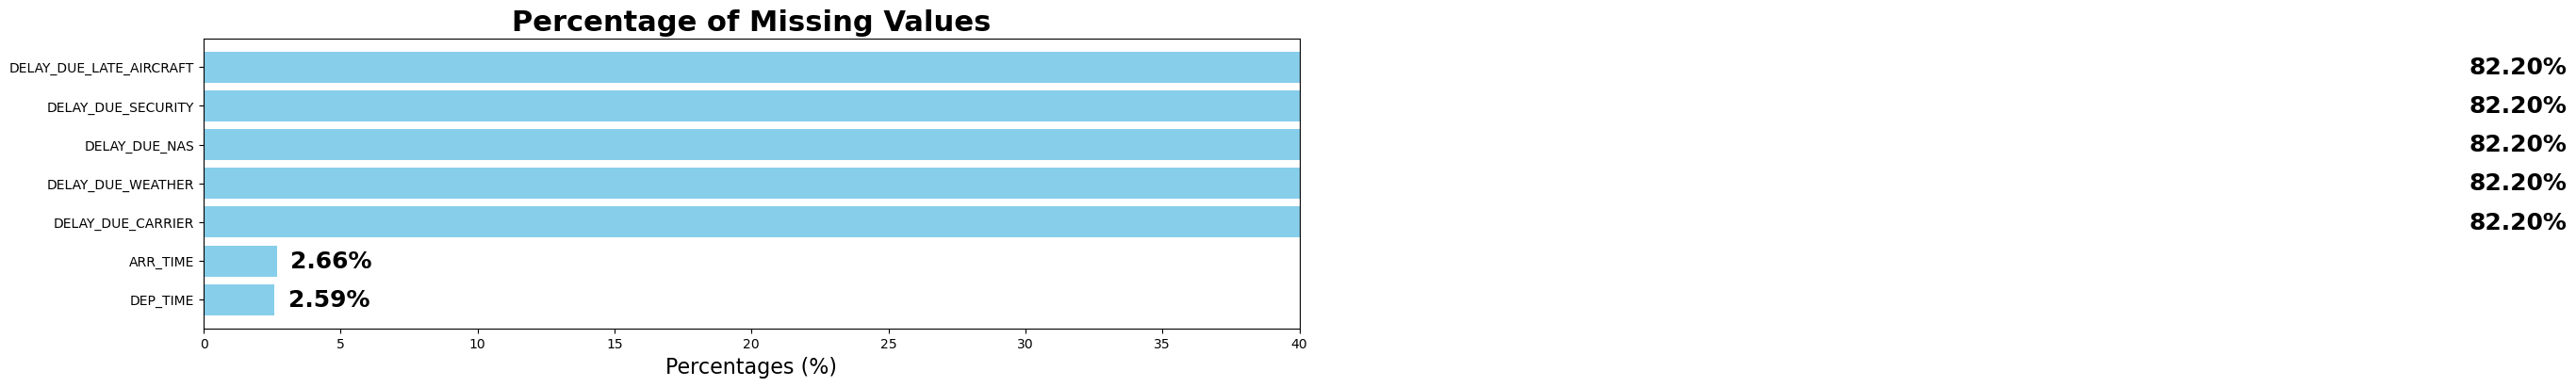

In [45]:
# Calculating the percentage of missing values for each column
missing_data = df_flights.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df_flights.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#87CEEB')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [46]:
df_flights_clean = df_flights.dropna(subset=["ARR_TIME","DEP_TIME"]).copy()

In [47]:
def hhmm_to_minutes(hhmm):
    # Converter valores nulos ou inválidos
    try:
        hhmm = int(hhmm)
        hours = hhmm // 100
        minutes = hhmm % 100
        return hours * 60 + minutes
    except:
        return None

# Converter os tempos para minutos
df_flights_clean.loc[:, "DEP_TIME_MIN"] =  df_flights_clean["DEP_TIME"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_DEP_TIME_MIN"] =  df_flights_clean["CRS_DEP_TIME"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "ARR_TIME_MIN"] =  df_flights_clean["ARR_TIME"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_ARR_TIME_MIN"] =  df_flights_clean["CRS_ARR_TIME"].apply(hhmm_to_minutes)

#for col in ["DEP_TIME", "CRS_DEP_TIME", "ARR_TIME", "CRS_ARR_TIME"]:
#    df_flights_clean[col + "_MIN"] = df_flights_clean[col].apply(hhmm_to_minutes)

# Calcular o TOTAL_DELAY
df_flights_clean["DEP_DELAY"] = (
    df_flights_clean["DEP_TIME_MIN"] - df_flights_clean["CRS_DEP_TIME_MIN"]
)

df_flights_clean["ARR_DELAY"] = (
    df_flights_clean["ARR_TIME_MIN"] - df_flights_clean["CRS_ARR_TIME_MIN"]
)


In [48]:
df_flights_clean.head(10)

,FL_DATE,AIRLINE_CODE,FL_NUMBER,ORIGIN,DEST,DEP_TIME,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,CANCELLED,...,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,Rating,Modelo Avião,DEP_TIME_MIN,CRS_DEP_TIME_MIN,ARR_TIME_MIN,CRS_ARR_TIME_MIN,DEP_DELAY,ARR_DELAY
0,2019-01-09,UA,1562,FLL,EWR,1151.0,1155,1501,1447.0,0.0,...,NaN,NaN,3.3,Boeing 737-200,711,715,887,901,-4,-14
1,2022-11-19,DL,1149,MSP,SEA,2114.0,2120,2315,2310.0,0.0,...,NaN,NaN,1.4,Airbus A340-600,1274,1280,1390,1395,-6,-5
2,2022-07-22,UA,459,DEN,MSP,1000.0,954,1252,1252.0,0.0,...,NaN,NaN,1.2,Boeing 787,600,594,772,772,6,0
3,2023-03-06,DL,2295,MSP,SFO,1608.0,1609,1829,1853.0,0.0,...,0.0,0.0,3.7,Airbus A330-200,968,969,1133,1109,-1,24
4,2020-02-23,NK,407,MCO,DFW,1838.0,1840,2041,2040.0,0.0,...,NaN,NaN,2.5,Airbus A330-900neo,1118,1120,1240,1241,-2,-1
5,2019-07-31,WN,665,DAL,OKC,1237.0,1010,1110,1331.0,0.0,...,0.0,0.0,5.8,Boeing 767-300,757,610,811,670,147,141
6,2023-06-11,AA,2134,DCA,BOS,1001.0,1010,1159,1130.0,0.0,...,NaN,NaN,1.1,Airbus A310,601,610,690,719,-9,-29
7,2019-07-08,YX,4464,HSV,DCA,1637.0,1643,1945,2008.0,0.0,...,0.0,0.0,2.6,Boeing 767-300,997,1003,1208,1185,-6,23
8,2023-02-12,NK,590,IAH,LAX,527.0,530,717,706.0,0.0,...,NaN,NaN,3.2,Boeing 767-200,327,330,426,437,-3,-11
9,2020-08-22,AS,223,SEA,FAI,2116.0,2125,2355,2356.0,0.0,...,NaN,NaN,3.1,Boeing 787-10,1276,1285,1436,1435,-9,1


In [49]:
df_cancelados1 = df_flights_clean[df_flights_clean["CANCELLED"] == 1.0].copy()
df_desviados1 = df_flights_clean[df_flights_clean["DIVERTED"] == 1.0].copy()

cancelled_percentage = (df_cancelados1.shape[0] / df_flights_clean.shape[0]) * 100
diverted_percentage = (df_desviados1.shape[0] / df_flights_clean.shape[0]) * 100

print(f"Cancelled flights%: {cancelled_percentage:.2f}\n Diverted flights%: {diverted_percentage:.2f}")


Cancelled flights%: 0.00
 Diverted flights%: 0.21


In [50]:
df_flights_clean = df_flights_clean[(df_flights["DIVERTED"] != 1.0)].copy()

/tmp/ipykernel_5803/1797977763.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_flights_clean = df_flights_clean[(df_flights["DIVERTED"] != 1.0)].copy()


In [51]:
df_flights_clean.drop(["CANCELLED", "DIVERTED", "DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "ARR_TIME_MIN", "CRS_ARR_TIME_MIN"], axis=1, inplace=True)

In [52]:
df_flights_clean.head(10)

,FL_DATE,AIRLINE_CODE,FL_NUMBER,ORIGIN,DEST,DEP_TIME,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,Rating,Modelo Avião,DEP_DELAY,ARR_DELAY
0,2019-01-09,UA,1562,FLL,EWR,1151.0,1155,1501,1447.0,1065.0,NaN,NaN,NaN,NaN,NaN,3.3,Boeing 737-200,-4,-14
1,2022-11-19,DL,1149,MSP,SEA,2114.0,2120,2315,2310.0,1399.0,NaN,NaN,NaN,NaN,NaN,1.4,Airbus A340-600,-6,-5
2,2022-07-22,UA,459,DEN,MSP,1000.0,954,1252,1252.0,680.0,NaN,NaN,NaN,NaN,NaN,1.2,Boeing 787,6,0
3,2023-03-06,DL,2295,MSP,SFO,1608.0,1609,1829,1853.0,1589.0,0.0,0.0,24.0,0.0,0.0,3.7,Airbus A330-200,-1,24
4,2020-02-23,NK,407,MCO,DFW,1838.0,1840,2041,2040.0,985.0,NaN,NaN,NaN,NaN,NaN,2.5,Airbus A330-900neo,-2,-1
5,2019-07-31,WN,665,DAL,OKC,1237.0,1010,1110,1331.0,181.0,141.0,0.0,0.0,0.0,0.0,5.8,Boeing 767-300,147,141
6,2023-06-11,AA,2134,DCA,BOS,1001.0,1010,1159,1130.0,399.0,NaN,NaN,NaN,NaN,NaN,1.1,Airbus A310,-9,-29
7,2019-07-08,YX,4464,HSV,DCA,1637.0,1643,1945,2008.0,613.0,0.0,0.0,23.0,0.0,0.0,2.6,Boeing 767-300,-6,23
8,2023-02-12,NK,590,IAH,LAX,527.0,530,717,706.0,1379.0,NaN,NaN,NaN,NaN,NaN,3.2,Boeing 767-200,-3,-11
9,2020-08-22,AS,223,SEA,FAI,2116.0,2125,2355,2356.0,1533.0,NaN,NaN,NaN,NaN,NaN,3.1,Boeing 787-10,-9,1


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 | Feature Engineering</p>

# <b></span><span style='color:#87CEEB'> RFM Features</span></b>

<div style="border-radius:10px; padding:15px; background-color:#87CEEB; font-size:120%; text-align:left; color: black;">
  <h2>Recency</h2>
  <p>Vamos usar a <b>recência</b> para analisar quão recente foi o último atraso.</p>

  <h2>Frequency</h2>
  <p>A <b>frequência</b> nos permite descobrir se os atrasos são acontecimentos recorrentes.</p>

  <h2>Monetary</h2>
  <p>Qual é a <b>quantidade</b> total de atrasos? aplicar aos aeroportos? companhias aereas? aos dois? Nem sei se faz sentido aplicar isto aqui ou nao</p>
</div>

# <b></span><span style='color:#87CEEB'> RFM Airline</span></b>

In [53]:
# Convert FL_DATE to datetime type
df_flights_clean['FL_DATE'] = pd.to_datetime(df_flights_clean['FL_DATE'])

# Convert FL_DATE to datetime and extract only the date
df_flights_clean['FL_DATE'] = df_flights_clean['FL_DATE'].dt.date

# Find the most recent DELAY date for each airline
airline_data = df_flights_clean.groupby('AIRLINE_CODE')['FL_DATE'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df_flights_clean['FL_DATE'].max()

# Convert FL_DATE to datetime type before subtraction
airline_data['FL_DATE'] = pd.to_datetime(airline_data['FL_DATE'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each airline
airline_data['Days_Since_Last_Delay'] = (most_recent_date - airline_data['FL_DATE']).dt.days

# Remove the FL_DATE column
airline_data.drop(columns=['FL_DATE'], inplace=True)

In [54]:
# Calculate the total number of flights made by each airline
total_flights = df_flights_clean.groupby('AIRLINE_CODE')['FL_DATE'].count().reset_index()
total_flights.rename(columns={'FL_DATE': 'Total_Flights'}, inplace=True)


# Merge the new features into the airline_data dataframe
airline_data = pd.merge(airline_data, total_flights, on='AIRLINE_CODE')

# Display the first few rows of the airline_data dataframe
airline_data.head()

,AIRLINE_CODE,Days_Since_Last_Delay,Total_Flights
0,9E,0,109848
1,AA,0,371218
2,AS,0,98294
3,B6,0,109447
4,DL,0,388475


In [55]:
# Calculate the total delay by each airline
df_flights_clean['Total_Delay'] = df_flights_clean['DEP_DELAY'] + df_flights_clean['ARR_DELAY']
total_delay = df_flights_clean.groupby('AIRLINE_CODE')['Total_Delay'].sum().reset_index()

# Calculate the average transaction value for each customer
average_delay = total_delay.merge(total_flights, on='AIRLINE_CODE')
average_delay['Average_Delay'] = average_delay['Total_Delay'] / average_delay['Total_Flights']

# Merge the new features into the airline_data dataframe
airline_data = pd.merge(airline_data, total_delay, on='AIRLINE_CODE')
airline_data = pd.merge(airline_data, average_delay[['AIRLINE_CODE', 'Average_Delay']], on='AIRLINE_CODE')

# Display the first few rows of the airline_data dataframe
airline_data.head()

,AIRLINE_CODE,Days_Since_Last_Delay,Total_Flights,Total_Delay,Average_Delay
0,9E,0,109848,-784574,-7.142360
1,AA,0,371218,-3687136,-9.932536
2,AS,0,98294,-2155953,-21.933719
3,B6,0,109447,-3500303,-31.981717
4,DL,0,388475,-5397054,-13.892925


In [56]:
airline_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Days_Since_Last_Delay,18.0,8.622222e+01,2.567486e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,1066.00000
Total_Flights,18.0,1.618779e+05,1.529934e+05,1.795100e+04,6.253550e+04,1.064650e+05,220739.25000,555869.00000
Total_Delay,18.0,-1.698285e+06,1.649324e+06,-5.397054e+06,-2.806454e+06,-1.093380e+06,-380816.25000,28021.00000
Average_Delay,18.0,-1.157064e+01,1.061807e+01,-3.198172e+01,-1.612837e+01,-8.537448e+00,-4.16719,1.45329


# <b></span><span style='color:#87CEEB'> RFM Flight</span></b>

In [57]:
# Find the most recent DELAY date for each airline
flight_data = df_flights_clean.groupby('FL_NUMBER')['FL_DATE'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df_flights_clean['FL_DATE'].max()

# Convert FL_DATE to datetime type before subtraction
flight_data['FL_DATE'] = pd.to_datetime(flight_data['FL_DATE'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each airline
flight_data['Days_Since_Last_Delay'] = (most_recent_date - flight_data['FL_DATE']).dt.days

# Remove the FL_DATE column
flight_data.drop(columns=['FL_DATE'], inplace=True)

In [58]:
# Calculate the total number of trips made by each flight
total_flights = df_flights_clean.groupby('FL_NUMBER')['FL_DATE'].count().reset_index()
total_flights.rename(columns={'FL_DATE': 'Total_Flights'}, inplace=True)


# Merge the new features into the flight_data dataframe
flight_data = pd.merge(flight_data, total_flights, on='FL_NUMBER')

# Display the first few rows of the flight_data dataframe
flight_data.head()

,FL_NUMBER,Days_Since_Last_Delay,Total_Flights
0,1,0,909
1,2,1,856
2,3,2,840
3,4,2,815
4,5,0,645


In [59]:
# Calculate the total delay by each airline
df_flights_clean['Total_Delay'] = df_flights_clean['DEP_DELAY'] + df_flights_clean['ARR_DELAY']
total_delay = df_flights_clean.groupby('FL_NUMBER')['Total_Delay'].sum().reset_index()

# Calculate the average transaction value for each customer
average_delay = total_delay.merge(total_flights, on='FL_NUMBER')
average_delay['Average_Delay'] = average_delay['Total_Delay'] / average_delay['Total_Flights']

# Merge the new features into the flight_data dataframe
flight_data = pd.merge(flight_data, total_delay, on='FL_NUMBER')
flight_data = pd.merge(flight_data, average_delay[['FL_NUMBER', 'Average_Delay']], on='FL_NUMBER')

# Display the first few rows of the flight_data dataframe
flight_data.head()

,FL_NUMBER,Days_Since_Last_Delay,Total_Flights,Total_Delay,Average_Delay
0,1,0,909,-31397,-34.540154
1,2,1,856,-15952,-18.635514
2,3,2,840,-8,-0.009524
3,4,2,815,5845,7.171779
4,5,0,645,-8110,-12.573643


In [60]:
flight_data.describe().T

,count,mean,std,min,25%,50%,75%,max
FL_NUMBER,7109.0,3570.122661,2081.684355,1.0,1778.000000,3555.000000,5333.000000,9562.000000
Days_Since_Last_Delay,7109.0,107.513434,286.005269,0.0,1.000000,3.000000,12.000000,1702.000000
Total_Flights,7109.0,409.875088,250.879566,1.0,226.000000,389.000000,599.000000,1194.000000
Total_Delay,7109.0,-4300.061612,9806.626198,-120905.0,-6717.000000,-1204.000000,786.000000,35742.000000
Average_Delay,7109.0,-8.600652,33.511357,-1420.0,-16.207827,-4.976027,3.785894,469.333333


# <b></span><span style='color:#87CEEB'> RFM Airport</span></b>

In [61]:
# Find the most recent DELAY date for each airline
airport_data = df_flights_clean.groupby('ORIGIN')['FL_DATE'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df_flights_clean['FL_DATE'].max()

# Convert FL_DATE to datetime type before subtraction
airport_data['FL_DATE'] = pd.to_datetime(airport_data['FL_DATE'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each airline
airport_data['Days_Since_Last_Delay'] = (most_recent_date - airport_data['FL_DATE']).dt.days

# Remove the FL_DATE column
airport_data.drop(columns=['FL_DATE'], inplace=True)

In [62]:
# Calculate the total number of trips made by each flight
total_flights = df_flights_clean.groupby('ORIGIN')['FL_DATE'].count().reset_index()
total_flights.rename(columns={'FL_DATE': 'Total_Flights'}, inplace=True)


# Merge the new features into the airport_data dataframe
airport_data = pd.merge(airport_data, total_flights, on='ORIGIN')

# Display the first few rows of the airport_data dataframe
airport_data.head()

,ORIGIN,Days_Since_Last_Delay,Total_Flights
0,ABE,3,1967
1,ABI,6,874
2,ABQ,0,9030
3,ABR,2,328
4,ABY,6,430


In [63]:
# Calculate the total delay by each airline
df_flights_clean['Total_Delay'] = df_flights_clean['DEP_DELAY'] + df_flights_clean['ARR_DELAY']
total_delay = df_flights_clean.groupby('ORIGIN')['Total_Delay'].sum().reset_index()

# Calculate the average transaction value for each customer
average_delay = total_delay.merge(total_flights, on='ORIGIN')
average_delay['Average_Delay'] = average_delay['Total_Delay'] / average_delay['Total_Flights']

# Merge the new features into the airport_data dataframe
airport_data = pd.merge(airport_data, total_delay, on='ORIGIN')
airport_data = pd.merge(airport_data, average_delay[['ORIGIN', 'Average_Delay']], on='ORIGIN')

# Display the first few rows of the airport_data dataframe
airport_data.head()

,ORIGIN,Days_Since_Last_Delay,Total_Flights,Total_Delay,Average_Delay
0,ABE,3,1967,247,0.125572
1,ABI,6,874,10071,11.522883
2,ABQ,0,9030,-9726,-1.077076
3,ABR,2,328,7236,22.060976
4,ABY,6,430,170,0.395349


In [64]:
airport_data.describe().T


,count,mean,std,min,25%,50%,75%,max
Days_Since_Last_Delay,380.0,54.331579,194.001634,0.000000e+00,0.0000,0.000000,4.250000,1587.000000
Total_Flights,380.0,7667.900000,18814.001334,6.000000e+00,327.7500,1090.500000,4594.500000,150749.000000
Total_Delay,380.0,-80445.100000,327593.456427,-2.584313e+06,-4243.0000,1055.500000,7753.500000,101595.000000
Average_Delay,380.0,-0.611599,20.041856,-2.561935e+02,-5.3282,1.961222,6.905779,75.603448


# <b></span><span style='color:#87CEEB'> Flight Diversity</span></b>

In [65]:
# Calculate the number of unique products purchased by each airline
unique_flights = df_flights_clean.groupby('AIRLINE_CODE')['FL_NUMBER'].nunique().reset_index()
unique_flights.rename(columns={'FL_NUMBER': 'Unique_Flights'}, inplace=True)

# Merge the new feature into the airline_data dataframe
airline_data = pd.merge(airline_data, unique_flights, on='AIRLINE_CODE')

# Display the first few rows of the airline_data dataframe
airline_data.head()

,AIRLINE_CODE,Days_Since_Last_Delay,Total_Flights,Total_Delay,Average_Delay,Unique_Flights
0,9E,0,109848,-784574,-7.142360,1141
1,AA,0,371218,-3687136,-9.932536,2864
2,AS,0,98294,-2155953,-21.933719,1764
3,B6,0,109447,-3500303,-31.981717,2323
4,DL,0,388475,-5397054,-13.892925,3018


# <b></span><span style='color:#87CEEB'> Geographic Features</span></b>

In [82]:
num_destinos = df_flights.groupby('ORIGIN')['DEST'].nunique().reset_index(name='num_destinos_distintos')
num_destinos

,ORIGIN,num_destinos_distintos
0,ABE,14
1,ABI,2
2,ABQ,27
3,ABR,1
4,ABY,1
...,...,...
375,XNA,27
376,XWA,2
377,YAK,2
378,YKM,1


# <b></span><span style='color:#87CEEB'> Seasonality & Trends</span></b>

In [77]:
rotas_frequentes = df_flights.groupby(['ORIGIN', 'DEST']).size().reset_index(name='num_voos')
rotas_frequentes

,ORIGIN,DEST,num_voos
0,ABE,ATL,398
1,ABE,BNA,48
2,ABE,CLT,483
3,ABE,DEN,1
4,ABE,DTW,292
...,...,...,...
7780,YAK,CDV,155
7781,YAK,JNU,168
7782,YKM,SEA,152
7783,YUM,DFW,210


# <b></span><span style='color:#87CEEB'> Distance</span></b>

In [78]:
df_flights['ROTA'] = df_flights['ORIGIN'] + '-' + df_flights['DEST']
rotas_ordenadas = df_flights[['ROTA', 'DISTANCE']].drop_duplicates().sort_values(by='DISTANCE', ascending=False)
rotas_longas = rotas_ordenadas.head(10)
rotas_curtas = rotas_ordenadas.tail(10)
rotas_longas

,ROTA,DISTANCE
751759,SFO-GUM,5812.0
1651,BOS-HNL,5095.0
106595,HNL-BOS,5095.0
42826,HNL-JFK,4983.0
7859,JFK-HNL,4983.0
6059,HNL-EWR,4962.0
20606,EWR-HNL,4962.0
12424,OGG-EWR,4904.0
107059,EWR-OGG,4904.0
67467,HNL-IAD,4817.0


In [79]:
rotas_curtas

,ROTA,DISTANCE
36556,CGI-PAH,45.0
294378,STT-STX,45.0
425365,DEC-SPI,43.0
20152,JNU-GST,41.0
169922,GST-JNU,41.0
10761,PSG-WRG,31.0
11743,WRG-PSG,31.0
137733,HHH-SAV,30.0
13920,SAV-HHH,30.0
57931,EGE-ASE,29.0


In [80]:
distancia_total_origem = df_flights.groupby('ORIGIN')['DISTANCE'].sum().reset_index(name='distancia_total_origem')
distancia_total_origem

,ORIGIN,distancia_total_origem
0,ABE,1318783.0
1,ABI,151447.0
2,ABQ,6127652.0
3,ABR,85324.0
4,ABY,63220.0
...,...,...
375,XNA,3023954.0
376,XWA,246786.0
377,YAK,66279.0
378,YKM,15656.0
